<a href="https://colab.research.google.com/github/thiagotandrade/ds_project/blob/master/DS_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO: 
- Separar os bathroomcnt em duas colunas: uma indicando a quantidade de banheiros completos e outra indicando a quantidade de banheiros fracionados (banheiros completos: converter o valor pra inteiro; banheiros fracionados: 1 se o bathroomcnt tiver decimal e 0 cc).
- Escolher as melhores features (usar XGBoost, ver correlação entre variáveis e alvo).

# Projeto 1 da Disciplina Data Science 2019.1, CIn - UFPE
# Competição do Kaggle: [Zillow Prize](https://www.kaggle.com/c/zillow-prize-1)

## Configurando ambiente

### Imports

In [0]:
!pip install missingpy
!pip install pyspark

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns


from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import QuantileDiscretizer
from sklearn.preprocessing import LabelEncoder

sc = SparkContext('local')
spark = SparkSession(sc)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [0]:
# Variável para indicar se a imputação já foi feita anteriormente (salvar tempo de processamento)
imputed = False

### Lendo versão 2016 dos arquivos CSV

In [0]:
props = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/merged_2016v2.csv',
                    header=0, sep=',', quotechar='"')
props_bkp = props.copy()

## 2. Pré-processamento dos dados

In [4]:
props.tail().transpose()

,90270,90271,90272,90273,90274
parcelid,11876798,12808516,12010248,14310905,14636609
airconditioningtypeid,1,NaN,1,NaN,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3,2,2,2.5,2.5
bedroomcnt,4,3,2,3,3
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,7,4,NaN,NaN
calculatedbathnbr,3,2,2,2.5,2.5
decktypeid,NaN,NaN,NaN,NaN,NaN


In [40]:
props.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.027500e+04,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,658.0,...,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04,90275.000000
mean,1.298466e+07,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,66.0,...,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13,0.011457
std,2.504510e+06,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,0.0,...,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11,0.161079
min,1.071174e+07,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,...,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13,-4.605000
25%,1.155950e+07,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,...,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13,-0.025300
50%,1.254734e+07,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,...,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13,0.006000
75%,1.422755e+07,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,66.0,...,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13,0.039200
max,1.629608e+08,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,66.0,...,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13,4.737000


In [0]:
# Não faz Sentido

# Inserir valor true na coluna 'fireplaceflag' se houve algum valor presente em fireplacecnt diferente de zero ou NaN
#props.loc[props['fireplacecnt'] != 0 | pd.notnull(props['fireplacecnt']),'fireplaceflag'] = "True"

### 2.1 Definição de tipos

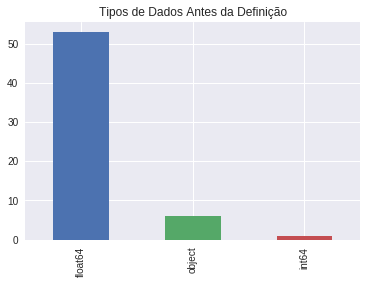

In [7]:
props_dtypes_before = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_before.plot.bar(title='Tipos de Dados Antes da Definição')

In [0]:
# Mudando colunas de tipo 'object' para tipo 'category'
object_type = props.select_dtypes(include=['object']).columns.values
props[object_type] = props[object_type].astype('category')

#Mudar tipo da coluna transaction date para 'datetime64' e separando a data em colunas
props['transactiondate'] = pd.to_datetime(props['transactiondate'])
props['transaction_year'] = props['transactiondate'].dt.year
props['transaction_month'] = props['transactiondate'].dt.month
props['transaction_day'] = props['transactiondate'].dt.day
props.drop(['transactiondate'], axis=1, inplace=True)

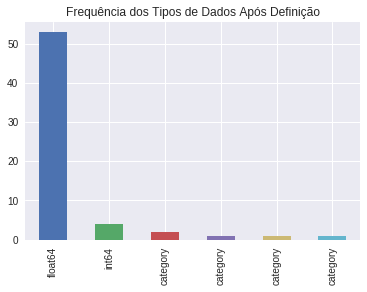

In [9]:
props_dtypes_after = props.dtypes.value_counts().sort_values(ascending=False)
props_dtypes_after.plot.bar(title='Frequência dos Tipos de Dados Após Definição')

### 2.2 Tratamento de dados ausentes

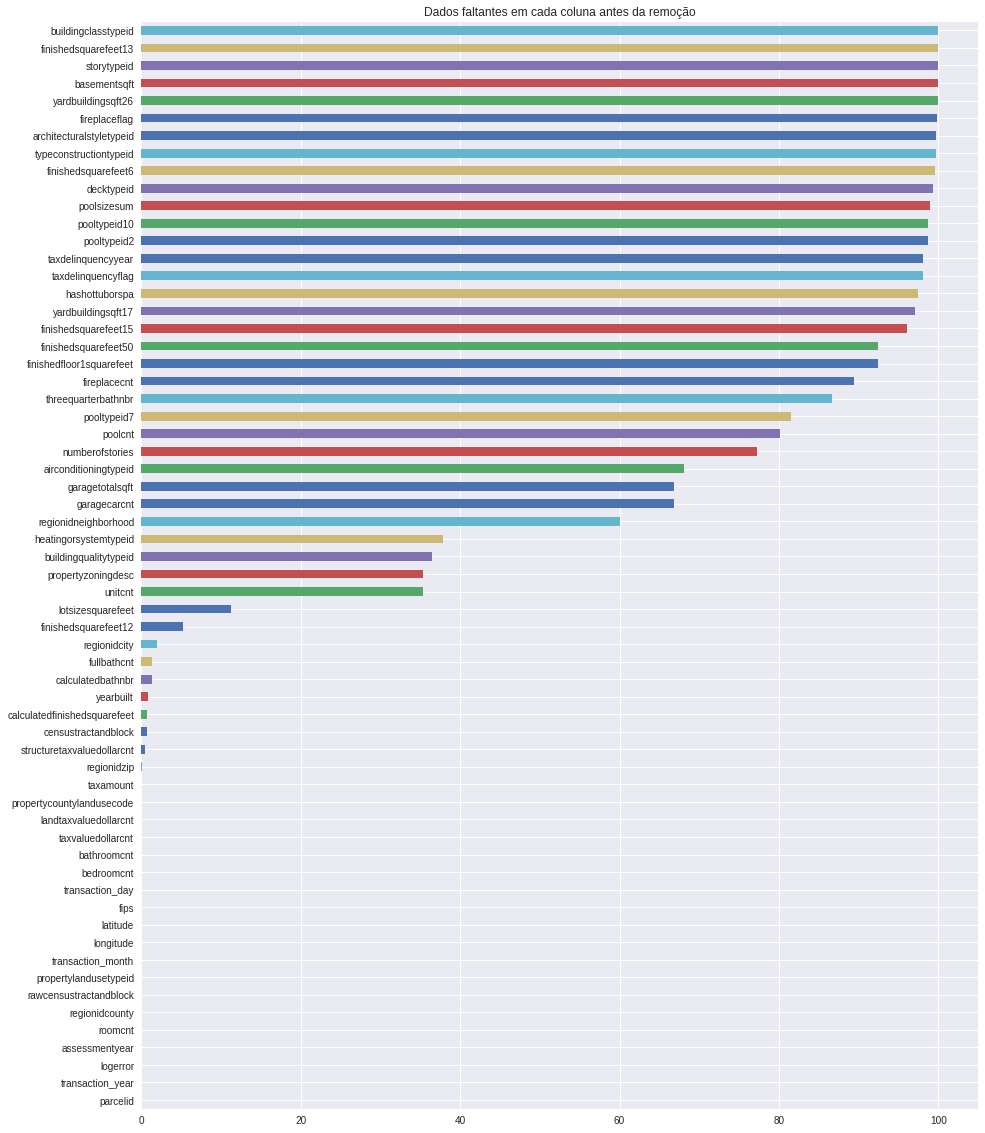

In [10]:
((props.isnull().sum()/len(props))*100).sort_values().plot.barh(figsize=(15,20), title='Dados faltantes em cada coluna antes da remoção')

#missingValueColumns = props.columns[props.isnull().any()].tolist()
#msno.bar(props[missingValueColumns])

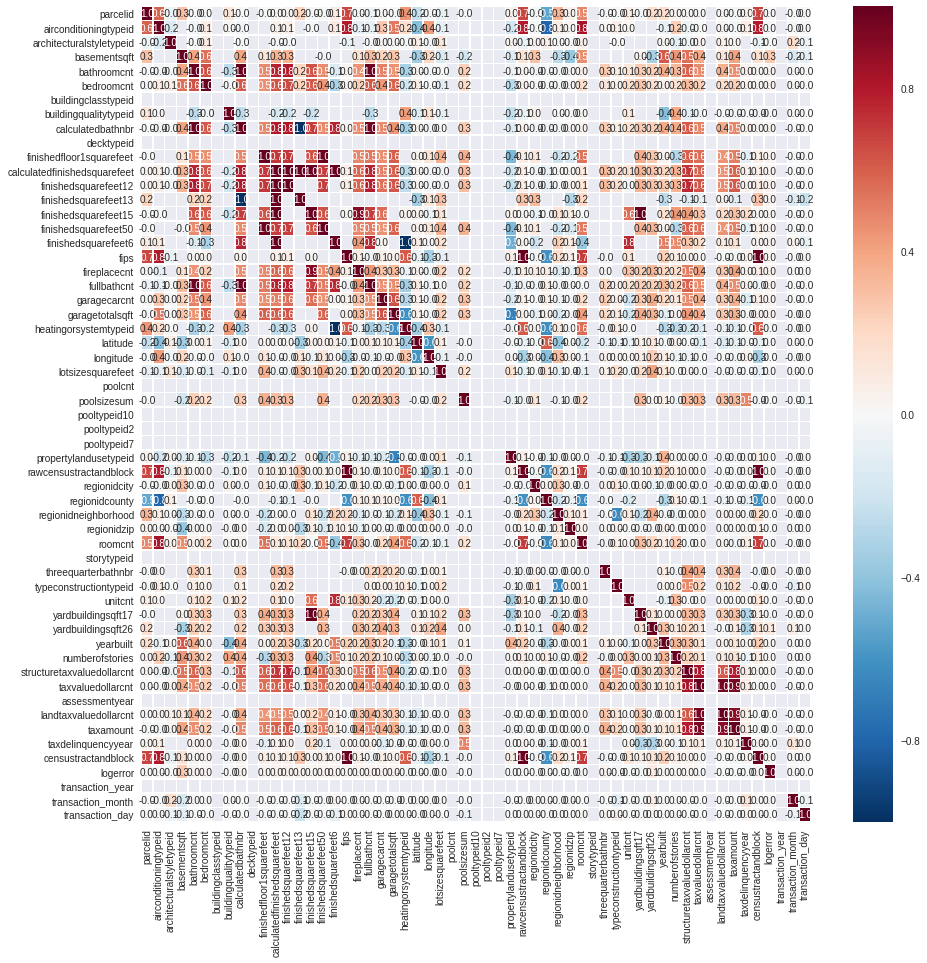

In [11]:
#msno.heatmap(props)
# All Columns Correlation
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(props.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
plt.show()

#### 2.2.1 Remoção de dados

In [12]:
props.shape

(90275, 62)

##### Remoção de Instâncias

In [0]:
#df.dropna(thresh=2)   #Drop row if it does not have at least two values that are **not** NaN

# Remover linhas com mais de 50% de dados ausentes
props.dropna(thresh=(0.5*len(props.columns.values)), axis=1, inplace=True)

##### Remoção de colunas

In [0]:
#A coluna 'fireplaceflag' não adiciona nenhuma informação útil pois df já possui 'fireplacecnt', então removemos:
props.drop(['fireplaceflag'], axis=1, inplace=True)

#A coluna 'calculatedbathnbr' é uma cópia da coluna 'bathroomcnt', então removemos:
props.drop(['calculatedbathnbr'], axis=1, inplace=True)

#A coluna 'calculatedfinishedsquarefeet' é uma cópia da coluna 'finishedsquarefeet12', então removemos:
props.drop(['calculatedfinishedsquarefeet'], axis=1, inplace=True)

# Remover colunas com mais de 70% de dados ausentes
props.dropna(thresh=0.70*len(props), axis=1, inplace=True)

##### Dataframe Resultante

In [15]:
print('Dataframe Resultante: \n')
props.shape
props.head().transpose()

Dataframe Resultante: 



,0,1,2,3,4
parcelid,17073783,17088994,17100444,17102429,17109604
bathroomcnt,2.5,1,2,1.5,2.5
bedroomcnt,3,2,3,2,4
calculatedfinishedsquarefeet,1264,777,1101,1554,2415
finishedsquarefeet12,1264,777,1101,1554,2415
fips,6111,6111,6111,6111,6111
fullbathcnt,2,1,2,1,2
latitude,3.43036e+07,3.42729e+07,3.43408e+07,3.43543e+07,3.42666e+07
longitude,-1.19287e+08,-1.19199e+08,-1.1908e+08,-1.19076e+08,-1.19165e+08
lotsizesquarefeet,1735,NaN,6569,7400,6326


In [16]:
nan_series_cols = props.isnull().sum()
print('Quantitativo de dados faltantes por coluna: \n')
nan_series_cols[nan_series_cols != 0].sort_values()
#nan_series_cols[nan_series_cols != 0].sort_values().plot.barh(figsize=(7,7), title='Quantidade de dados faltantes para as colunas que possuem')

Quantitativo de dados faltantes por coluna: 



propertycountylandusecode           1
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               1
taxamount                           6
regionidzip                        35
structuretaxvaluedollarcnt        380
censustractandblock               605
calculatedfinishedsquarefeet      661
yearbuilt                         756
fullbathcnt                      1182
regionidcity                     1803
finishedsquarefeet12             4679
lotsizesquarefeet               10150
dtype: int64

#### 2.2.2 Imputação de dados

[Obtendo colunas que contém valores NaN](https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null)

In [0]:
# Get columns that have any NaN value
nan_columns = props.columns[props.isnull().any()]

Baseando-se correlação para medir algum impacto na imputação:

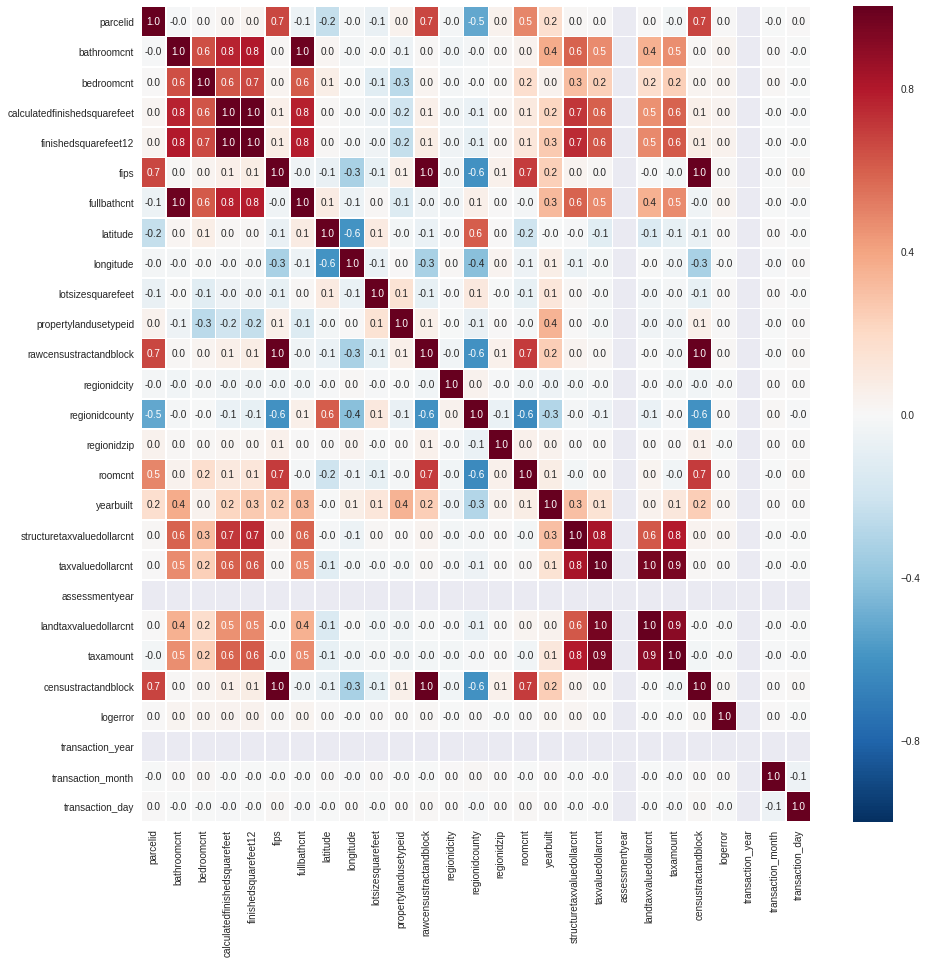

In [18]:
#msno.heatmap(props[nan_columns], figsize=(15,15))
# All Columns Correlation
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(props.corr(), annot=True, linewidths=.5, fmt='.1f',ax=ax)
plt.show()

##### Dados Categóricos [aqui](https://www.datacamp.com/community/tutorials/categorical-data) e [aqui](https://scikit-learn.org/stable/modules/impute.html)

In [0]:
cat_df_nan = props[nan_columns].select_dtypes(include=['category']).copy()

In [20]:
cat_df_nan.head()

,propertycountylandusecode
0,1128
1,1129
2,1111
3,1110
4,1111


In [21]:
print('Total NaN values in categorical data: ' + str(cat_df_nan.isnull().values.sum()))
print(cat_df_nan.isnull().sum())

Total NaN values in categorical data: 1
propertycountylandusecode    1
dtype: int64


Tentar usar o fancyimpute do sklearn para fazer a imputação com outros algoritmos fora o kNN

Usando kNN para imputação de dados categóricos

In [0]:
category_type = props.select_dtypes(include=['category']).columns.values
for c in category_type:
  props[c] = props[c].cat.codes

In [0]:
def saveToCsv(df, columns, index):
  
  df_out = pd.DataFrame(data=df)
  props_df.columns = props.columns.values.tolist()
  df_out.set_index(index, inplace=True, drop=True)
  df_out.to_csv('props_imputed.csv')
  
  from google.colab import files
  files.download('props_imputed.csv')

In [24]:
'''

  Se já executou anteriormente, settar imputed para True.
  Se não, settar imputed para False para fazer a imputação.
  
'''

if(imputed):
  props_imputed = pd.read_csv('https://raw.githubusercontent.com/thiagotandrade/ds_project/master/Database/props_imputed.csv',
                             header=0, sep=',', quotechar='"')
else:
  from missingpy import MissForest
  imputer = MissForest()
  props_imputed = imputer.fit_transform(props)
  saveToCsv(props_imputed, props.columns.values.tolist(), 'parcelid')

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


NameError: ignored

In [0]:
#lb_make = LabelEncoder()
#props['propertycountylandusecode'] = lb_make.fit_transform(props['propertycountylandusecode'])

#props_knn = KNN(k=3).fit_transform(props)

##### Dados Numéricos

In [0]:
num_df_nan = props[nan_columns].select_dtypes(exclude=['category']).copy()
#num_nan = props[list(set(props.columns.values).difference(num_df_nan.columns.values))]

In [0]:
num_df_nan.shape

### 2.3 Normalização e discretização

#### 2.3.2 Normalização

#### 2.3.1 Discretização

In [0]:
# Pyspark QuantileDiscretizer: Discretizar a coluna 'yearbuilt'
props_spark = spark.createDataFrame(props,props.columns.values.tolist())
props_spark_result = QuantileDiscretizer(numBuckets=10, inputCol="yearbuilt",outputCol="year_built_intervals").fit(props_spark).transform(props_spark)
props_spark_result.show()

### 2.4 Limpeza de dados

#### 2.4.1 Univariado

#### 2.4.2 Bivariado

#### 2.4.3 Multivariado

## Criação de Novas Features

## Visualização de Dados

#### Distribuição da localização das propriedades

In [0]:
props['latitude'] /= 1e6
props['longitude'] /= 1e6

In [0]:
plt.figure(figsize=(12,12))
sns.jointplot(x=props.latitude.values, y=props.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [0]:
#Save for later

#Get all null columns as dataframe 
#print(props[props.isnull().any(axis=1)][nan_columns].head())

#props_train = pd.merge(props, train, on='parcelid', how='left')

#msno.dendrogram(props)

# Changing type of columns with Ids to unsigned short int
#id_columns = props.filter(regex='id').columns.values
#props[id_columns] = props[id_columns].astype('uint16')

# Para a coluna propertycountylandusecode não precisamos de imputação, logo apenas transformamos as categorias para código
# cat_df_props['propertycountylandusecode'] = cat_df_props['propertycountylandusecode'].cat.codes.astype('int16')
#cat_df_props['propertyzoningdesc'] = cat_df_props['propertyzoningdesc'].cat.codes.astype('int16')

###############################################################################################################################

#Para excluir

# Não podemos usar o one hot encoder pois precisariamos criar 240 novas colunas para um dataframe com 3 mi instâncias
#cat_df_props['propertycountylandusecode'].cat.categories

#prop_county_land_use_code = cat_df_props['propertycountylandusecode'].cat.codes
#prop_county_land_use_code

#lb_make = LabelEncoder()
#cat_df_props['propertycountylandusecode'] = lb_make.fit_transform(cat_df_props['propertycountylandusecode'])